In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import torch


import numpy as np

#from src.unet import UNet
#from src.diffusion_model import GaussianDiffusionModelCast
#from src.get_data import NSTK_SR as NSTK
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

# from torch_ema import ExponentialMovingAverage
import scipy.stats
from src.hat_arch import HAT

import h5py

MSE: 7.2815604


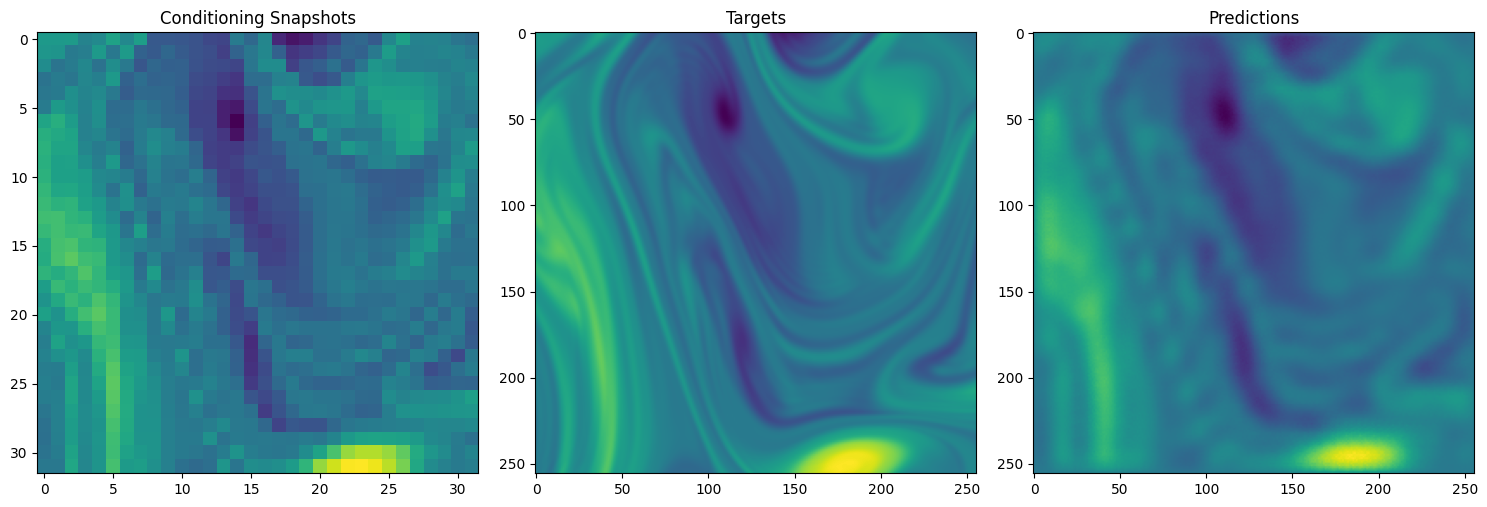

In [8]:
# Load the saved samples
def load_samples(file_path):
    samples = np.load(file_path, allow_pickle=True).item()
    return samples

# Define the path to your .npy file
file_path = '/pscratch/sd/y/yanggao/SuperDiffusion/samples/samples_superres_HAT09251_1.npy'

# Load the sample data
samples = load_samples(file_path)

# Extract data from the loaded dictionary
conditioning_snapshots = samples['conditioning_snapshots']
targets = samples['targets']
predictions = samples['predictions']

# Squeeze the data to remove the extra dimension if necessary
conditioning_snapshots = conditioning_snapshots.squeeze()
targets = targets.squeeze()
predictions = predictions.squeeze()

loss = np.mean((predictions - targets)**2)
print('MSE:', loss)

# Plotting the first element from each array as an example
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(conditioning_snapshots[0], cmap='viridis')
ax[0].set_title('Conditioning Snapshots')

ax[1].imshow(targets[0], cmap='viridis')
ax[1].set_title('Targets')

ax[2].imshow(predictions[0], cmap='viridis')
ax[2].set_title('Predictions')

plt.tight_layout()
plt.show()

In [3]:
model = HAT(img_size=32, patch_size=1, in_chans=1,
        window_size=8, img_range=1., depths=[6, 6, 6, 6, 6, 6],
        embed_dim=256, num_heads=[8,8,8,8,8,8], mlp_ratio=4, upsampler='pixelshuffle',
        upscale=8, resi_connection='1conv') #TODO

criterion = torch.nn.MSELoss(reduction='mean')

/pscratch/sd/y/yanggao/SuperDiffusion/venv/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:

checkpoint_path = "/pscratch/sd/y/yanggao/SuperDiffusion/checkpoints/checkpoint_full092550.pt"

print(f'Loading model from {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, weights_only=True)
state_dict = checkpoint["model"]
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace("module.", "")  # Remove "module." prefix
    new_state_dict[new_key] = value
        
model.load_state_dict(new_state_dict)

Loading model from /pscratch/sd/y/yanggao/SuperDiffusion/checkpoints/checkpoint_full092550.pt


<All keys matched successfully>

In [5]:
# Convert the numpy array to a PyTorch tensor and move it to the correct device (GPU in this case)
conditioning_tensor = torch.from_numpy(conditioning_snapshots[0]).to('cuda')
model.to('cuda')

# Ensure the model is in evaluation mode and perform inference
model.eval()

with torch.no_grad():
    predictions = model(conditioning_tensor)
    

Loss: 0.5275467038154602


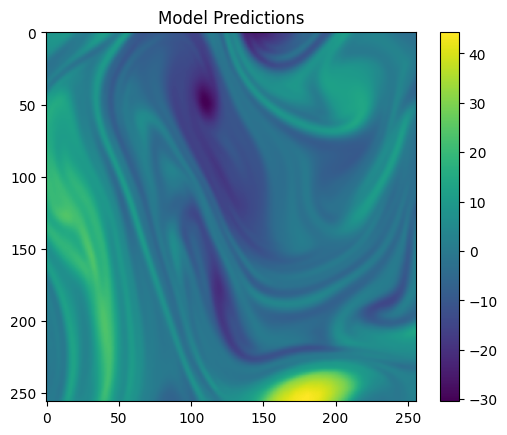

In [6]:
# Move predictions to the CPU and convert to numpy for plotting, if necessary
predictions_cpu = predictions.detach().cpu().numpy()


# Assuming predictions is a 2D tensor (for a single-channel image or similar data)
plt.imshow(predictions_cpu[0][0][:, :], cmap='viridis')  # You can choose a different colormap, like 'gray', 'plasma', etc.
loss = criterion(predictions.detach().cpu().flatten(), torch.from_numpy(targets[0]).flatten())
print(f'Loss: {loss.item()}')

plt.colorbar()  # Optional: adds a color bar for reference
plt.title("Model Predictions")
plt.show()